# Readme
这个notebook用于画出论文中要用到的图3

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import copy
import argparse
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import json
from utils.tools import dotdict
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from matplotlib import cm
from scipy import stats
import math
from scipy.optimize import curve_fit
import matplotlib
from data_provider.data_loader import fixed_files
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

from matplotlib.font_manager import FontProperties
from scipy.stats import wilcoxon, ttest_ind, mannwhitneyu, ttest_rel

font = {'family' : 'Arial'}

matplotlib.rcParams['mathtext.fontset'] = 'custom'

matplotlib.rcParams['mathtext.rm'] = 'Arial'

matplotlib.rcParams['mathtext.it'] = 'Arial'

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42 # make the text editable for Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rc('font', **font0)

# matplotlib.rc('text', usetex=False)
def set_ax_linewidth(ax, bw=1.5):
    ax.spines['bottom'].set_linewidth(bw)
    ax.spines['left'].set_linewidth(bw)
    ax.spines['top'].set_linewidth(bw)
    ax.spines['right'].set_linewidth(bw)

def set_ax_font_size(ax, fontsize=10):
    ax.tick_params(axis='y',
                 labelsize=fontsize # y轴字体大小设置
                  ) 
    ax.tick_params(axis='x',
                 labelsize=fontsize # x轴字体大小设置
                  ) 

def set_draft(the_plt, other_ax=''):
    ax = the_plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel('')
    plt.ylabel('')
    if other_ax:
        other_ax.axes.xaxis.set_ticklabels([])
        other_ax.axes.yaxis.set_ticklabels([])
        other_ax.set_ylabel('')
        other_ax.set_xlabel('')

def set_draft_fig(fig):
    for ax in fig.axes:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
    
x_y_label_size = 12 
title_size = 12 
convert_mm_to_inch = 1/25.4
dot_size = 9

metric = 'rmse' # rmse or mae

这里写上a、b、c三个图的绘图函数的实现

In [10]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def plot_significane(ax, Xs,Ys,P_value,height=0.2):
    '''
    ax: The matplotlib.axes to conduct the plot
    Xs: The x-coordinates of the line
    Ys: The y-coordinates of the line
    P_value: The significance test value
    height: The vertical line height
    '''
    # plot the line
    Ys[1] += height
    Ys[2] += height
    ax.plot(Xs, Ys, lw=2, c='#595959')
    # ax.text((Xs[0]+Xs[2])*0.5, Ys[0]+height,convert_pvalue_to_asterisks(P_value), ha='center', va='bottom', color="k")
    ax.text((Xs[0]+Xs[2])*0.5, Ys[0]+height,"%.2f" % P_value, ha='center', va='bottom', color="k")
    
def plot_overal_performance(NCA_model_paths, LFP_model_paths):
    def collect_preds(cycleNumber_preds):
        '''Collect the preds from each cycle number'''
        cycleNumber_preds = list(cycleNumber_preds.values())
        total_preds = []
        for preds in cycleNumber_preds:
            total_preds += [np.mean(preds,axis=1)]
        total_preds = np.concatenate(total_preds,axis=0)
        return total_preds
    
    fig,(ax1,ax2) = plt.subplots(1,2,
                                    figsize=(7,4),
                                    dpi=600,
                                    sharey=False)
    ''' 根据trajectory上的每一个预测值来做显著性分析 '''
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer'] # the model names
    plot_colors = []
    plot_labels = []
    NCA_model_scores = {} # This includes the averaged scores for five conditions
    NCA_model_detailedScores = {} # This includes the averaged scores for each cell in the testing set
    NCA_model_detailedSampleScores = {}
    LFP_model_scores = {} # This includes the averaged scores for five conditions
    LFP_model_detailedScores = {} # This includes the averaged scores for each cell in the testing set
    LFP_model_detailedSampleScores = {}

    for index in range(len(NCA_model_paths)):
        NCA_mp = NCA_model_paths[index]
        if 'FT' in NCA_mp or 'DA' in NCA_mp:
            # fine-tune is not considered in this figure
            continue
        LFP_mp = LFP_model_paths[index]
        the_color = colors[index]

        model_name = model_names[index]
        plot_colors.append(the_color)
        plot_labels.append(model_name)
        # save the NCA data
        with open(f'{NCA_mp}cell_{metric}s_detailed.json') as f:
            NCA_detailed_Qd_errors = json.load(f)
            NCA_detailed_Ed_errors = json.load(open(f'{NCA_mp}Ed_cell_{metric}s_detailed.json'))
            condition_errors = {}
            for cell_name, Qd_errors in NCA_detailed_Qd_errors.items():
                condition = cell_name.split('_1-')[0]
                Ed_errors = NCA_detailed_Ed_errors[cell_name]
                errors = (np.array(Qd_errors) + np.array(Ed_errors)) / 2
                condition_errors[condition] = condition_errors.get(condition, []) + [np.mean(errors)]
                NCA_model_detailedSampleScores[model_name] = NCA_model_detailedSampleScores.get(model_name, []) + list(errors)
            for condition, errors in condition_errors.items():
                NCA_model_scores[model_name] = NCA_model_scores.get(model_name, []) + [np.mean(errors)]
        # save the LFP data
        with open(f'{LFP_mp}cell_{metric}s_detailed.json') as f:
            LFP_detailed_Qd_errors = json.load(f)
            LFP_detailed_Ed_errors = json.load(open(f'{LFP_mp}Ed_cell_{metric}s_detailed.json'))
            condition_errors = {}
            for cell_name, Qd_errors in LFP_detailed_Qd_errors.items():
                condition = cell_name.split('_1-')[0]
                Ed_errors = LFP_detailed_Ed_errors[cell_name]
                errors = (np.array(Qd_errors) + np.array(Ed_errors)) / 2
                condition_errors[condition] = condition_errors.get(condition, []) + [np.mean(errors)]
                LFP_model_detailedSampleScores[model_name] = LFP_model_detailedSampleScores.get(model_name, []) + list(errors)
            for condition, errors in condition_errors.items():
                LFP_model_scores[model_name] = LFP_model_scores.get(model_name, []) + [np.mean(errors)]
        
    # compute the significance test
    # for NCA
    for model_name, scores in NCA_model_scores.items():
        NCA_model_scores[model_name] = np.mean(scores)
    sorted_NCA_model_scores = sorted(NCA_model_scores.items(), key=lambda x:x[1], reverse=False)
    best_modelName, second_modelName = sorted_NCA_model_scores[0][0], sorted_NCA_model_scores[1][0]
    res = wilcoxon(NCA_model_detailedSampleScores[best_modelName],NCA_model_detailedSampleScores[second_modelName])
    p_value = res.pvalue
    # _, p_value = ttest_ind(NCA_model_detailedScores[best_modelName],NCA_model_detailedScores[second_modelName])
    print(f'NCA p-value:{p_value}')
    saved_NCA_data = {}
    for model_name, data in NCA_model_scores.items():
        saved_NCA_data[model_name] = [data]
    df = pd.DataFrame(saved_NCA_data)
    df.to_csv(f'./fig3/fig3a/NCA_data_{metric}.csv',index=False)
    ax1.bar(x=plot_labels, height=list(NCA_model_scores.values()),color=plot_colors)
    plot_significane(ax1,[0,0,1,1],[max(list(NCA_model_scores.values()))+0.01 for _ in range(4)],p_value,height=0.01)

    y_major_locator=MultipleLocator(0.02)
        
    ax1.yaxis.set_major_locator(y_major_locator)
    ax1.set_xticks([])
    # ax1.set_ylim((0.7,1.0))
    if metric == 'mae':
        ax1.set_ylabel('MAE')
    else:
        ax1.set_ylabel('RMSE')
    ax1.set_title('Overall NCA results')
    set_ax_font_size(ax1)
    set_ax_linewidth(ax1)
    custom_lines = [Line2D([0], [0], color=plot_colors[0],label=plot_labels[0], lw=5),
                    Line2D([0], [0], color=plot_colors[1],label=plot_labels[1], lw=5),
                    Line2D([0], [0], color=plot_colors[2],label=plot_labels[2], lw=5),
                    Line2D([0], [0], color=plot_colors[3],label=plot_labels[3], lw=5)]
    ax1.legend(handles=custom_lines)
    # for LFP
    for model_name, scores in LFP_model_scores.items():
        LFP_model_scores[model_name] = np.mean(scores)
    sorted_LFP_model_scores = sorted(LFP_model_scores.items(), key=lambda x:x[1], reverse=False)
    best_modelName, second_modelName = sorted_LFP_model_scores[0][0], sorted_LFP_model_scores[1][0]
    res = wilcoxon(LFP_model_detailedSampleScores[best_modelName],LFP_model_detailedSampleScores[second_modelName])
    p_value = res.pvalue
    # _, p_value = ttest_ind(LFP_model_detailedScores[best_modelName],LFP_model_detailedScores[second_modelName])
    print(f'LFP p-value:{p_value}')
    saved_LFP_data = {}
    for model_name, data in LFP_model_scores.items():
        saved_LFP_data[model_name] = [data]
    df = pd.DataFrame(saved_LFP_data)
    df.to_csv(f'./fig3/fig3a/LFP_data_{metric}.csv',index=False)
    ax2.bar(x=plot_labels, height=list(LFP_model_scores.values()),color=plot_colors)
    plot_significane(ax2,[0,0,1,1],[max(list(LFP_model_scores.values()))+0.01 for _ in range(4)],p_value,height=0.01)

    y_major_locator=MultipleLocator(0.02)
        
    ax2.yaxis.set_major_locator(y_major_locator)
    ax2.set_xticks([])
    # ax2.set_ylim((0.6,1.0))
    if metric == 'mae':
        ax2.set_ylabel('MAE')
    else:
        ax2.set_ylabel('RMSE')
    ax2.set_title('Overall LFP results')
    set_ax_font_size(ax2)
    set_ax_linewidth(ax2)
    fig.tight_layout()
    plt.savefig(f'./fig3/fig3a/a_{metric}.pdf', bbox_inches = 'tight')
    plt.show()


def plot_NCA_target_source_boxes(NCA_model_paths):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    my_pal = {"MAGNet": '#f08080', "Informer":'#1e90ff', "FT-Informer":'#808080', 'DA-Informer': '#eeb5a1'}
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer','DA-Informer'] # the model names
    box_model_names = ['MAGNet','Informer','FT-Informer','DA-Informer']
    total_alphas = []
    cell_names = []
    total_model_names = []
    hue_name = ''
    fig = plt.figure(figsize=(6,4))
    for index in range(len(NCA_model_paths)):
        NCA_mp = NCA_model_paths[index]
        model_name = model_names[index]
        if model_name not in box_model_names:
            continue
        with open(f'{NCA_mp}cell_{metric}s_detailed.json') as f:
            NCA_detailed_Qd_errors = json.load(f)
            NCA_detailed_Ed_errors = json.load(open(f'{NCA_mp}Ed_cell_{metric}s_detailed.json'))
            for cell_name, Qd_errors in NCA_detailed_Qd_errors.items():
                Ed_errors = NCA_detailed_Ed_errors[cell_name]
                errors = (np.array(Qd_errors) + np.array(Ed_errors)) / 2
                cell_name = cell_name.split('_1-')[0]
                cell_name = cell_name.split('NCA_')[-1]
                total_alphas += list(errors)
                cell_names += [cell_name for _ in range(len(errors))]
                total_model_names += [model_name for _ in range(len(errors))]
    df = pd.DataFrame({hue_name:total_model_names,
                       f'{metric}':total_alphas,
                       'Conditions':cell_names})   
    df.to_csv(f'./fig3/fig3b/NCA_boxplot_{metric}.csv',index=False)
    ax=sns.boxplot(x='Conditions',y=f'{metric}', hue=hue_name,whis=1.5, data=df, width=0.7,palette=my_pal, hue_order=['MAGNet','Informer','DA-Informer','FT-Informer'])   
    ax.legend_.remove()
    y_major_locator=MultipleLocator(0.05)
    ax.yaxis.set_major_locator(y_major_locator)
    plt.axvline(1-0.5,c='k')
    plt.title('Results of target and source conditions on NCA dataset')
    plt.xlabel('Conditions')
    if metric == 'mae':
        plt.ylabel('MAE')
    else:
        plt.ylabel('RMSE')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    fig.tight_layout()
    plt.savefig(f'./fig3/fig3b/b_{metric}.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

def plot_NCA_target_source_boxes_all(NCA_model_paths):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    my_pal = {"MAGNet": '#f08080', "Informer":'#1e90ff', 
              "FT-Informer":'#808080', "One-shot LSTM": '#800080',
              "BiLSTM": '#ffa500','DA-Informer':'#eeb5a1'}
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer','DA-Informer'] # the model names
    box_model_names = model_names
    total_alphas = []
    cell_names = []
    total_model_names = []
    hue_name = ''
    fig = plt.figure(figsize=(10,4))
    for index in range(len(NCA_model_paths)):
        NCA_mp = NCA_model_paths[index]
        model_name = model_names[index]
        if model_name not in box_model_names:
            continue
        with open(f'{NCA_mp}cell_{metric}s_detailed.json') as f:
            NCA_detailed_Qd_errors = json.load(f)
            NCA_detailed_Ed_errors = json.load(open(f'{NCA_mp}Ed_cell_{metric}s_detailed.json'))
            for cell_name, Qd_errors in NCA_detailed_Qd_errors.items():
                Ed_errors = NCA_detailed_Ed_errors[cell_name]
                errors = (np.array(Qd_errors) + np.array(Ed_errors)) / 2
                cell_name = cell_name.split('_1-')[0]
                cell_name = cell_name.split('NCA_')[-1]
                total_alphas += list(errors)
                cell_names += [cell_name for _ in range(len(errors))]
                total_model_names += [model_name for _ in range(len(errors))]
    df = pd.DataFrame({hue_name:total_model_names,
                       metric:total_alphas,
                       'Conditions':cell_names})   
    df.to_csv(f'./fig3/SI/NCA_boxplot_all_{metric}.csv', index=False)
    ax=sns.boxplot(x='Conditions',y=metric, hue=hue_name,whis=1.5, data=df,width=0.7,palette=my_pal, order=['CY25-1','CY25-025','CY25-05','CY35-05','CY45-05'],
                boxprops={'linewidth':0}, whiskerprops={'color':'k'})   
    # ax=sns.barplot(x='Conditions',y='alpha-acc', hue=hue_name, data=df, palette=my_pal, order=['CY25-1','CY25-025','CY25-05','CY35-05','CY45-05'],
    #             errorbar='sd',err_kws={'lw':1.5},capsize=0.2,saturation=1,hue_order=['MAGNet','Informer','One-shot LSTM','BiLSTM','DA-Informer','FT-Informer'])   
    ax.legend_.remove()
    plt.axvline(1-0.5,c='k')
    plt.title('Results of target and source conditions on NCA dataset')
    plt.xlabel('Conditions')
    if metric == 'mae':
        plt.ylabel('MAE')
    else:
        plt.ylabel('RMSE')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    fig.tight_layout()
    plt.savefig(f'./fig3/SI/NCA_boxplot_all_{metric}.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

def plot_LFP_seen_unseen_boxes(LFP_model_paths, rank_from_large_imrpvoement_to_low=False):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer','DA-Informer'] # the model names
    unseen_files = fixed_files.NE_unseen_test_files
    seen_files = [i for i in fixed_files.NE_test_files if i not in unseen_files]
    unseen_files = [i.split('.')[0] for i in unseen_files]
    seen_files =  [i.split('.')[0] for i in seen_files]
    total_model_names = []
    cell_policies = []
    total_alphas = []
    hue_name = ''
    fig=plt.figure(figsize=(12,4))

    my_order = ['6C(20%)-4.5C', '4.9C(27%)-4.75C', '6C(40%)-4C', '5.2C(71%)-3C', '5.6C(47%)-4C', '5.6C(58%)-3.5C', '4C(31%)-5C', '6C(31%)-4.25C', '4.4C(55%)-6C', '3.6C(22%)-5.5C', '6C(52%)-3.5C', '5.6C(65%)-3C', '2C(2%)-5C', '1C(4%)-6C', '2C(7%)-5.5C', '2C(10%)-6C']
    cell_policy_data = {}
    for cell_policy in my_order:
        cell_policy_data.setdefault(cell_policy, [[],[]])
    for index in range(len(LFP_model_paths[:2])):
        # The first two paths are paths to our model and Informer respeectively.
        LFP_mp = LFP_model_paths[index]
        if 'FT' in LFP_mp:
            # no fine-tuning for LFP dataset since no target data is available
            continue
        model_name = model_names[index]
        with open(f'{LFP_mp}cell_{metric}s_detailed.json') as f:
            LFP_detailed_Qd_errors = json.load(f)
            LFP_detailed_Ed_errors = json.load(open(f'{LFP_mp}Ed_cell_{metric}s_detailed.json'))
            for cell_name, Qd_errors in LFP_detailed_Qd_errors.items():
                Ed_errors = LFP_detailed_Ed_errors[cell_name]
                errors = (np.array(Qd_errors) + np.array(Ed_errors)) / 2
                # cell_name = cell_name.split('.')[0]
                # cell_policy = fixed_files.NE_name_policy[cell_name]
                cell_policy = cell_name
                total_alphas += list(errors)
                cell_policies += [cell_policy for _ in range(len(errors))]
                total_model_names += [model_name for _ in range(len(errors))]
                
                cell_policy_data[cell_policy][0] += list(errors)
                cell_policy_data[cell_policy][1] += [model_name for _ in range(len(errors))]
    new_total_model_names = []
    new_total_alphas = []
    new_cell_policies = []
    for cell_policy in my_order:
        new_total_alphas += cell_policy_data[cell_policy][0]
        new_total_model_names += cell_policy_data[cell_policy][1]
        new_cell_policies += [cell_policy for _ in range(len(cell_policy_data[cell_policy][0]))]
        

    df = pd.DataFrame({hue_name:new_total_model_names,
                       f'{metric}':new_total_alphas,
                       'cell policy':new_cell_policies})   
    df.to_csv(f'./fig3/fig3c/LFP_boxplot_{metric}.csv',index=False)   
    if rank_from_large_imrpvoement_to_low:
        # 画出每个电池的箱线图
        # 在各自的区域，将电池按从改进大的到改进小的排序
        unseen_files_scores = {}
        seen_files_scores = {}
        for unseen_file in unseen_files:
            cell_name = unseen_file.split('.')[0]
            cell_policy = fixed_files.NE_name_policy[cell_name]
            MAGNet_score = df.loc[(df[hue_name]=='MAGNet') & (df['cell policy']==cell_policy)][metric].values
            Informer_score = df.loc[(df[hue_name]=='Informer') & (df['cell policy']==cell_policy)][metric].values 
            # improvement = np.median(MAGNet_score) - np.median(Informer_score)
            improvement = (np.median(MAGNet_score) - np.median(Informer_score)) / np.median(Informer_score)
            unseen_files_scores[cell_policy] = improvement
 
        # 进行排序
        unseen_files_scores = sorted(unseen_files_scores.items(),key=lambda x:x[1],reverse=False)
        print('Order', list(dict(unseen_files_scores).keys()))
        count = 1
        for policy, improvement in dict(unseen_files_scores).items():
            print(count, policy,improvement)
            count+=1
        sns.boxplot(x='cell policy',y=f'{metric}',hue=hue_name,whis=1.5, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= list(dict(unseen_files_scores).keys()),
            boxprops={'linewidth':0}, whiskerprops={'color':'k'})    
    else:
        sns.boxplot(x='cell policy',y=f'{metric}',hue=hue_name,whis=1.5, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= unseen_files,
                    boxprops={'linewidth':0}, whiskerprops={'color':'k'})    
    # sns.boxplot(x='cell name',y='alpha-acc',hue=hue_name, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= unseen_files + seen_files,showfliers = False,boxprops={'linewidth':0})
    # plt.axvline(len(unseen_files)-0.5,c='k')
    plt.legend(loc='upper left')
    plt.title('Results of unseen conditions on LFP dataset')
    plt.xlabel('Condition')
    if metric == 'mae':
        plt.ylabel('MAE')
    else:
        plt.ylabel('RMSE')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    plt.xticks(rotation=20)
    fig.tight_layout()
    plt.savefig(f'./fig3/fig3c/c_{metric}.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

In [11]:
def return_model_paths(args_path,old_args_path,FT_args_path,oneShotLSTM_path,vLSTM_path, DA_path=None):
    with open(f'{args_path}/args.txt', 'r') as f:
        args = json.load(f)

    with open(f'{old_args_path}/args.txt', 'r') as f:
        old_args = json.load(f)

    if FT_args_path != 'noFT':
        with open(f'{FT_args_path}/args.txt', 'r') as f:
            FT_args = json.load(f)
    else:
        FT_args = old_args # randomly set. This is never used for LFP

    with open(f'{oneShotLSTM_path}/args.txt', 'r') as f:
        oneShotLSTM_args = json.load(f)
    with open(f'{vLSTM_path}/args.txt', 'r') as f:
        vLSTM_args = json.load(f)
    if DA_path is not None:
        with open(f'{DA_path}/args.txt', 'r') as f:
            DA_args = json.load(f)
    setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                args['model_id'],
                args['model'],
                args['data'],
                args['learning_rate'],
                args['meta_learning_rate'],
                args['moving_avg'],
                args['features'],
                args['seq_len'],
                args['label_len'],
                args['pred_len'],
                args['d_model'],
                args['n_heads'],
                args['e_layers'],
                args['d_layers'],
                args['d_ff'],
                args['factor'],
                args['factor2'],
                args['embed'],
                args['distil'],
                args['val_ratio'],
                args['des'], args['loss'], args['vali_loss'], args['dropout'], args['batch_size'], args['wd'], args['meta_beta'],
                args['auxiliary_gamma'], args['lradj'], 0)
    old_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                old_args['model_id'],
                old_args['model'],
                old_args['data'],
                old_args['learning_rate'],
                old_args['meta_learning_rate'],
                old_args['moving_avg'],
                old_args['features'],
                old_args['seq_len'],
                old_args['label_len'],
                old_args['pred_len'],
                old_args['d_model'],
                old_args['n_heads'],
                old_args['e_layers'],
                old_args['d_layers'],
                old_args['d_ff'],
                old_args['factor'],
                old_args['factor2'],
                old_args['embed'],
                old_args['distil'],
                old_args['val_ratio'],
                old_args['des'], old_args['loss'], old_args['vali_loss'], old_args['dropout'], old_args['batch_size'], old_args['wd'], old_args['meta_beta'],
                old_args['auxiliary_gamma'], old_args['lradj'], 0)
    FT_setting = 'FT_{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                FT_args['model_id'],
                FT_args['model'],
                FT_args['data'],
                FT_args['learning_rate'],
                FT_args['meta_learning_rate'],
                FT_args['moving_avg'],
                FT_args['features'],
                FT_args['seq_len'],
                FT_args['label_len'],
                FT_args['pred_len'],
                FT_args['d_model'],
                FT_args['n_heads'],
                FT_args['e_layers'],
                FT_args['d_layers'],
                FT_args['d_ff'],
                FT_args['factor'],
                FT_args['factor2'],
                FT_args['embed'],
                FT_args['distil'],
                FT_args['val_ratio'],
                FT_args['des'], FT_args['loss'], FT_args['vali_loss'], FT_args['dropout'], FT_args['batch_size'], FT_args['wd'], FT_args['meta_beta'],
                FT_args['auxiliary_gamma'], FT_args['lradj'], 0)
    OneshotLSTM_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                oneShotLSTM_args['model_id'],
                oneShotLSTM_args['model'],
                oneShotLSTM_args['data'],
                oneShotLSTM_args['learning_rate'],
                oneShotLSTM_args['meta_learning_rate'],
                oneShotLSTM_args['moving_avg'],
                oneShotLSTM_args['features'],
                oneShotLSTM_args['seq_len'],
                oneShotLSTM_args['label_len'],
                oneShotLSTM_args['pred_len'],
                oneShotLSTM_args['d_model'],
                oneShotLSTM_args['n_heads'],
                oneShotLSTM_args['e_layers'],
                oneShotLSTM_args['d_layers'],
                oneShotLSTM_args['d_ff'],
                oneShotLSTM_args['factor'],
                oneShotLSTM_args['factor2'],
                oneShotLSTM_args['embed'],
                oneShotLSTM_args['distil'],
                oneShotLSTM_args['val_ratio'],
                oneShotLSTM_args['des'], oneShotLSTM_args['loss'], oneShotLSTM_args['vali_loss'], oneShotLSTM_args['dropout'], oneShotLSTM_args['batch_size'], oneShotLSTM_args['wd'], oneShotLSTM_args['meta_beta'],
                oneShotLSTM_args['auxiliary_gamma'], oneShotLSTM_args['lradj'], 0)
    vLSTM_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                vLSTM_args['model_id'],
                vLSTM_args['model'],
                vLSTM_args['data'],
                vLSTM_args['learning_rate'],
                vLSTM_args['meta_learning_rate'],
                vLSTM_args['moving_avg'],
                vLSTM_args['features'],
                vLSTM_args['seq_len'],
                vLSTM_args['label_len'],
                vLSTM_args['pred_len'],
                vLSTM_args['d_model'],
                vLSTM_args['n_heads'],
                vLSTM_args['e_layers'],
                vLSTM_args['d_layers'],
                vLSTM_args['d_ff'],
                vLSTM_args['factor'],
                vLSTM_args['factor2'],
                vLSTM_args['embed'],
                vLSTM_args['distil'],
                vLSTM_args['val_ratio'],
                vLSTM_args['des'], vLSTM_args['loss'], vLSTM_args['vali_loss'], vLSTM_args['dropout'], vLSTM_args['batch_size'], vLSTM_args['wd'], vLSTM_args['meta_beta'],
                vLSTM_args['auxiliary_gamma'], vLSTM_args['lradj'], 0)
    if DA_path is not None:
        DA_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}_DA'.format(
                    DA_args['model_id'],
                    DA_args['model'],
                    DA_args['data'],
                    DA_args['learning_rate'],
                    DA_args['meta_learning_rate'],
                    DA_args['moving_avg'],
                    DA_args['features'],
                    DA_args['seq_len'],
                    DA_args['label_len'],
                    DA_args['pred_len'],
                    DA_args['d_model'],
                    DA_args['n_heads'],
                    DA_args['e_layers'],
                    DA_args['d_layers'],
                    DA_args['d_ff'],
                    DA_args['factor'],
                    DA_args['factor2'],
                    DA_args['embed'],
                    DA_args['distil'],
                    DA_args['val_ratio'],
                    DA_args['des'], DA_args['loss'], DA_args['vali_loss'], DA_args['dropout'], DA_args['batch_size'], DA_args['wd'], DA_args['meta_beta'],
                    DA_args['auxiliary_gamma'], DA_args['lradj'], 0)
        DA_folder_path = './detailed_results/' + DA_setting + '/' # path DA-Informer
    # setting = 'NCA_Equation2'
    folder_path = './detailed_results/' + setting + '/'
    old_folder_path = './detailed_results/' + old_setting + '/'
    FT_folder_path = './detailed_results/' + FT_setting + '/'
    osLSTM_folder_path = './detailed_results/' + OneshotLSTM_setting + '/' # path to one-shot LSTM
    vLSTM_folder_path = './detailed_results/' + vLSTM_setting + '/' # path to one-shot vanilla LSTM
    
    if DA_path is not None:
        model_paths = [folder_path,old_folder_path,osLSTM_folder_path,vLSTM_folder_path,FT_folder_path,DA_folder_path]
    else:
        model_paths = [folder_path,old_folder_path,osLSTM_folder_path,vLSTM_folder_path,FT_folder_path]
    return model_paths


# For NCA
# Ours
NCA_args_path = './results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossawmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
# NCA_args_path =  './results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossawmse_vallossnw_dp0.0_bs32_wd0_mb0.5_agamma0.25_lradjtype4_0'
# Informer
NCA_old_args_path =  './results/NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb2_agamma0.25_lradjtype4_0' 
# Fine-tune
NCA_FT_args_path = './results/FT_NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb2_agamma0.25_lradjtype4_0'
# Domain adaptation
NCA_DA_args_path = './results/NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm12_nh4_el2_dl2_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
# one-shot LSTM
NCA_osLSTM_args_path = './results/NCA_OSLSTMv2_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm4_nh4_el2_dl1_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
# vanilla LSTM
NCA_vLSTM_args_path = './results/NCA_vLSTM_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm4_nh4_el2_dl1_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0.0001_mb0.25_agamma0.25_lradjtype4_0'

# For LFP
LFP_args_path = './results/NE_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossawmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'
LFP_old_args_path = './results/NE_Informer_Batteries_cycle_SLMove_lr0.0075_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm8_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'
LFP_osLSTM_args_path = './results/NE_OSLSTMv2_Batteries_cycle_SLMove_lr0.0075_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el1_dl1_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'
LFP_vLSTM_args_path = './results/NE_vLSTM_Batteries_cycle_SLMove_lr0.0075_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'

NCA_model_paths = return_model_paths(NCA_args_path,NCA_old_args_path,NCA_FT_args_path,NCA_osLSTM_args_path,NCA_vLSTM_args_path,NCA_DA_args_path)
LFP_model_paths = return_model_paths(LFP_args_path,LFP_old_args_path,'noFT',LFP_osLSTM_args_path,LFP_vLSTM_args_path,None)

meta NOT subset; don't know how to subset; dropped


NCA p-value:6.312398558183734e-13
LFP p-value:0.0


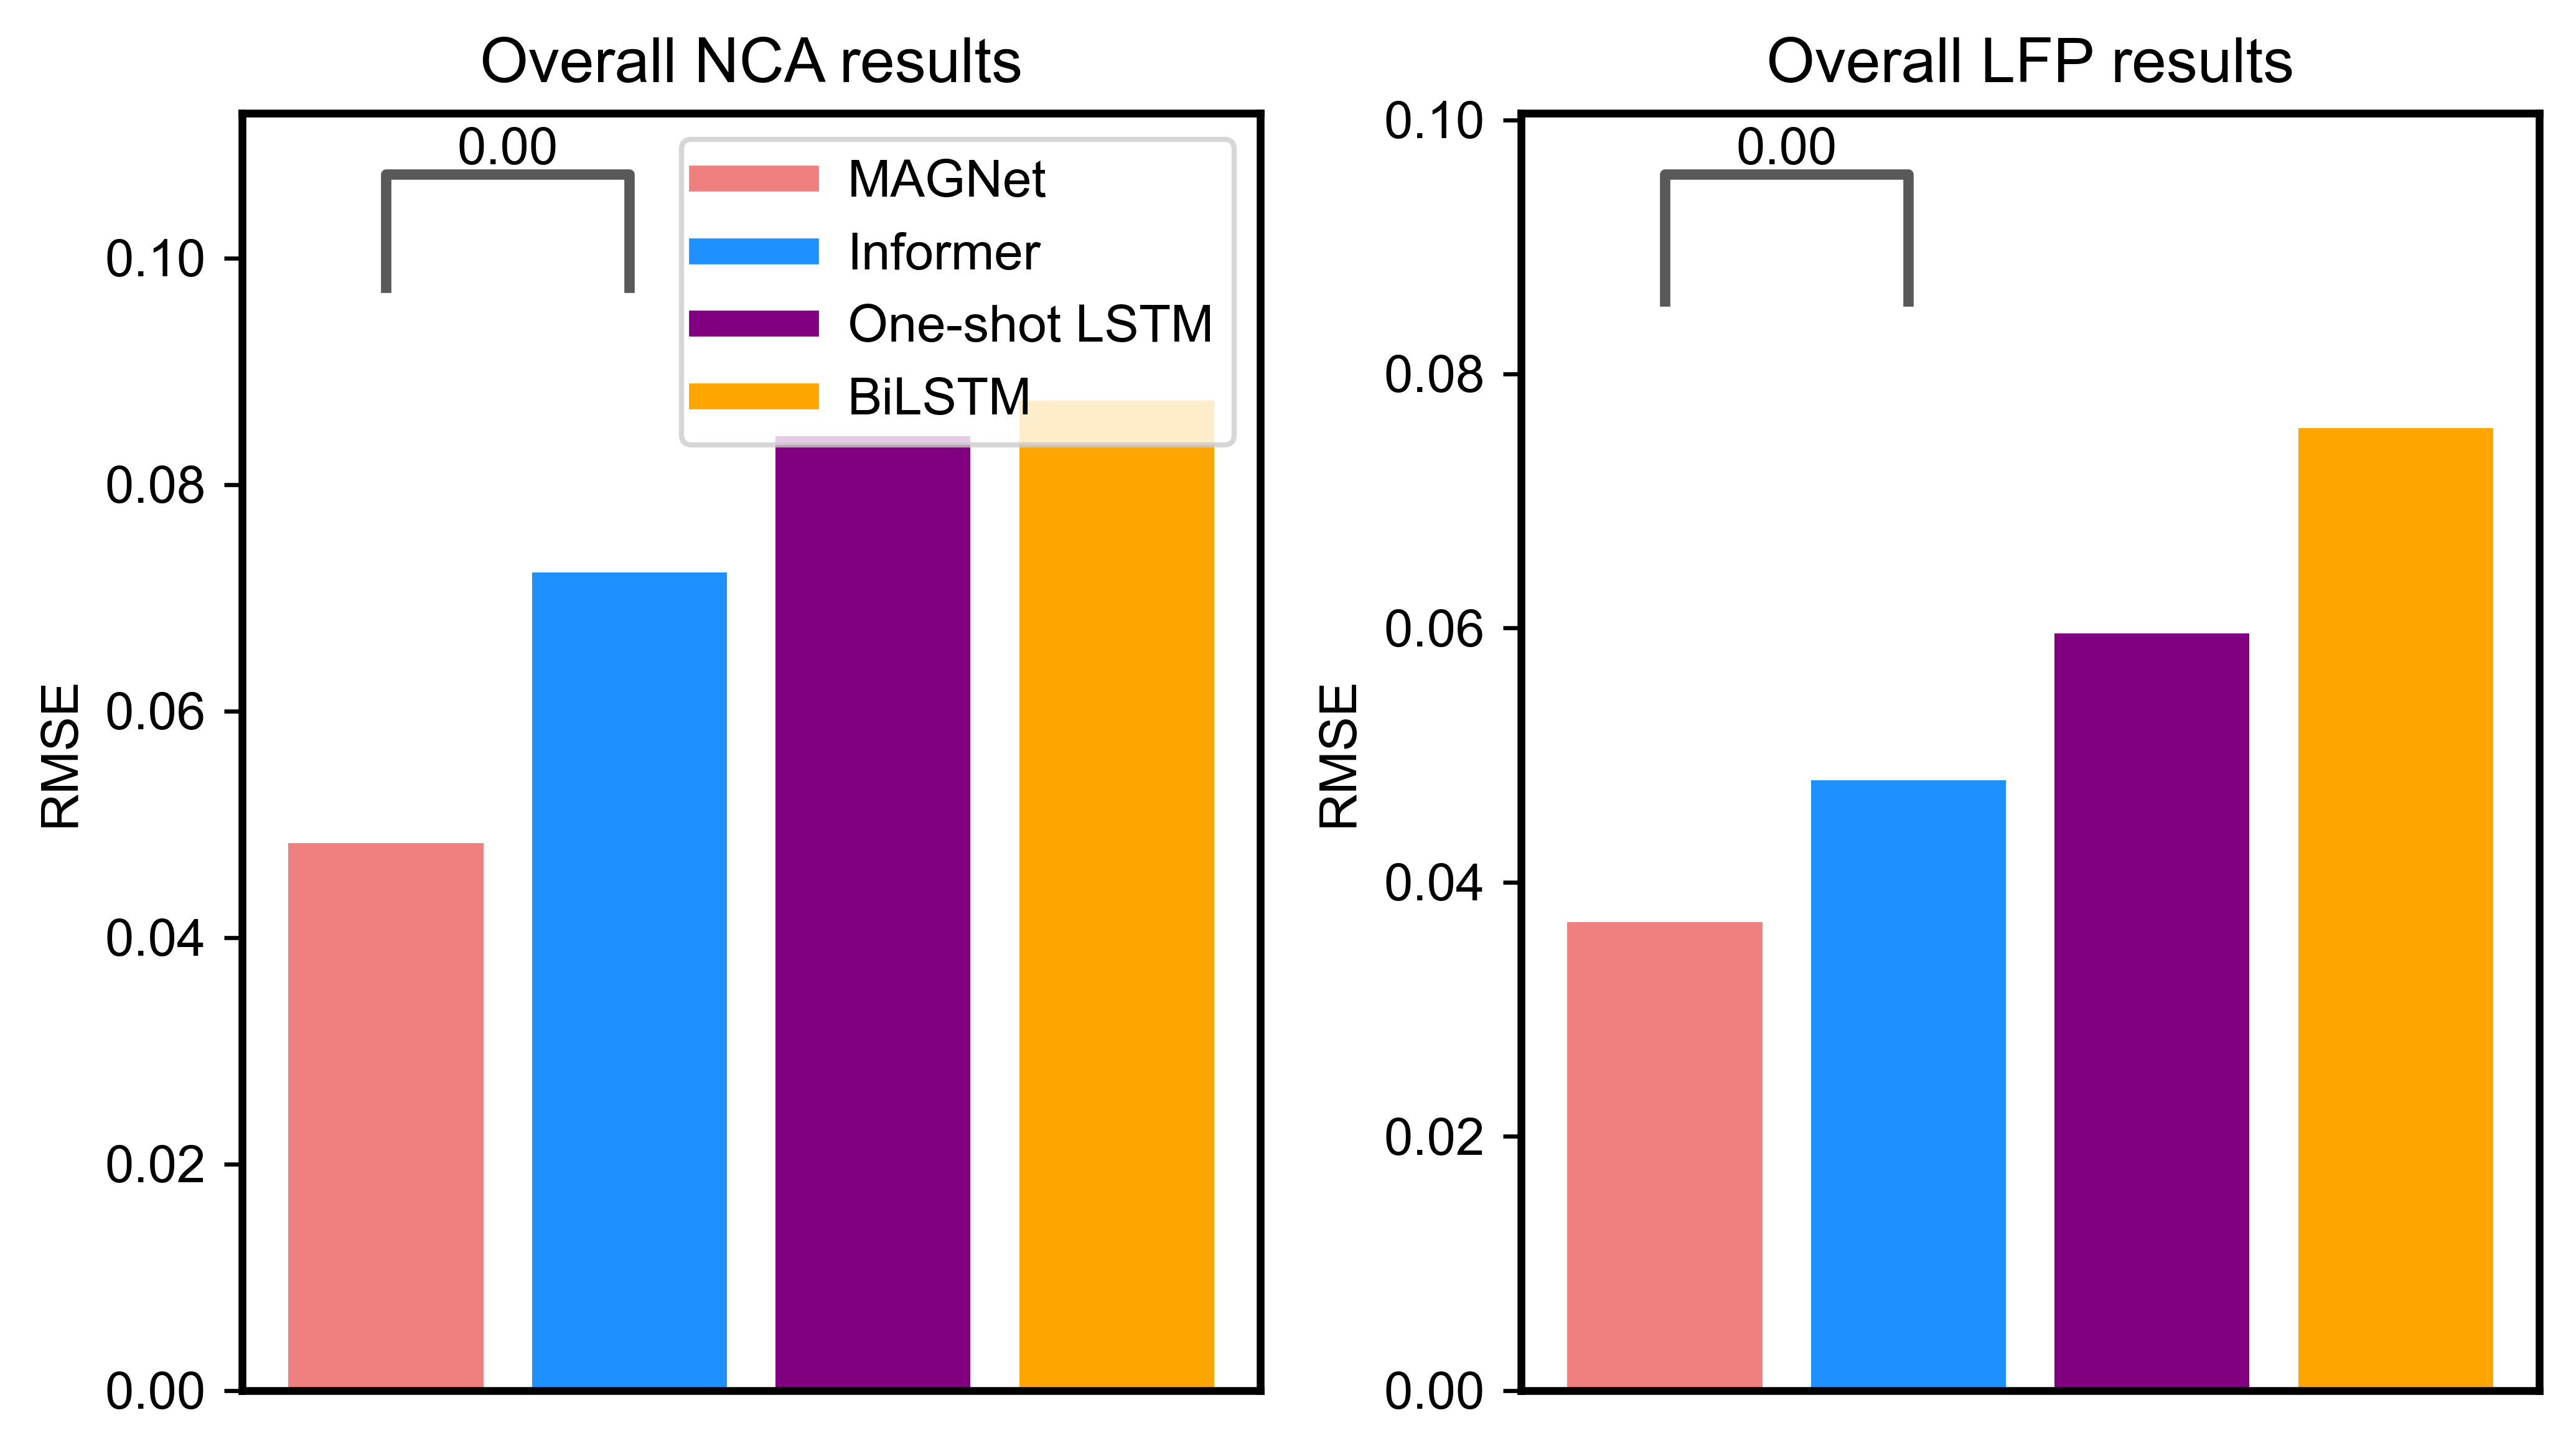

In [12]:
plot_overal_performance(NCA_model_paths,LFP_model_paths)

In [13]:
# plot_alphaAcc_vs_sampleRatio(NCA_model_paths)

用箱线图表示各个模型在NCA数据集上的表现

meta NOT subset; don't know how to subset; dropped


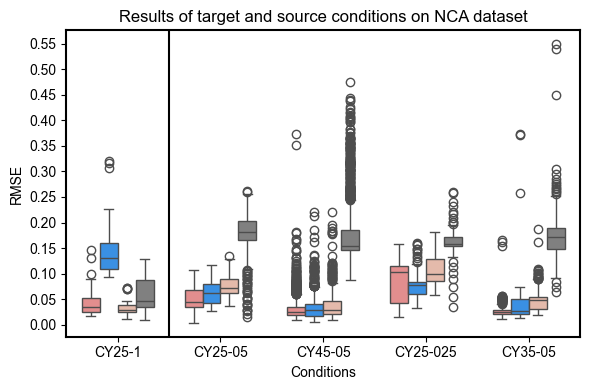

In [14]:
plot_NCA_target_source_boxes(NCA_model_paths)

meta NOT subset; don't know how to subset; dropped


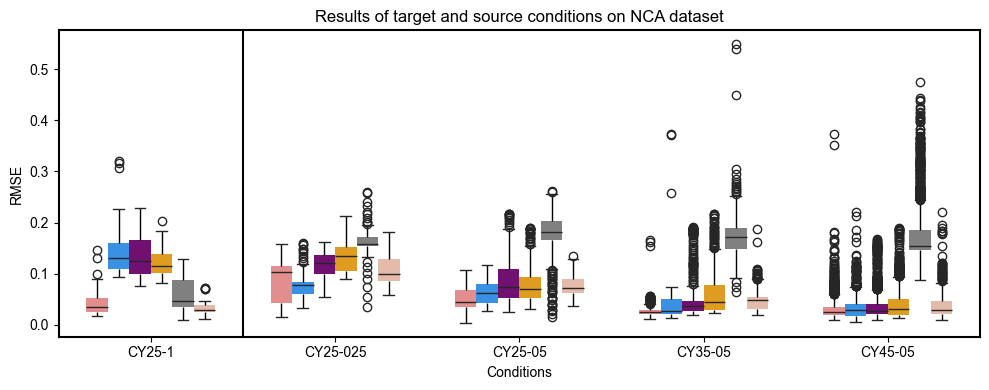

In [15]:
plot_NCA_target_source_boxes_all(NCA_model_paths)

Order ['6C(20%)-4.5C', '4.9C(27%)-4.75C', '6C(40%)-4C', '5.2C(71%)-3C', '5.6C(47%)-4C', '5.6C(58%)-3.5C', '4C(31%)-5C', '6C(31%)-4.25C', '4.4C(55%)-6C', '3.6C(22%)-5.5C', '6C(52%)-3.5C', '5.6C(65%)-3C', '2C(2%)-5C', '1C(4%)-6C', '2C(7%)-5.5C', '2C(10%)-6C']
1 6C(20%)-4.5C -0.5178087851631745
2 4.9C(27%)-4.75C -0.42273676687880235
3 6C(40%)-4C -0.41605878767322885
4 5.2C(71%)-3C -0.37126619733624194
5 5.6C(47%)-4C -0.34364949955684343
6 5.6C(58%)-3.5C -0.3192576348963203
7 4C(31%)-5C -0.3032631238561345
8 6C(31%)-4.25C -0.2691335601522733
9 4.4C(55%)-6C -0.21791820722029687
10 3.6C(22%)-5.5C -0.21631386002605826
11 6C(52%)-3.5C -0.20346774601727896
12 5.6C(65%)-3C -0.12843250043011337
13 2C(2%)-5C -0.041949136280474926
14 1C(4%)-6C 0.029247809623605008
15 2C(7%)-5.5C 0.03207526927707391
16 2C(10%)-6C 0.057674115891990244


meta NOT subset; don't know how to subset; dropped


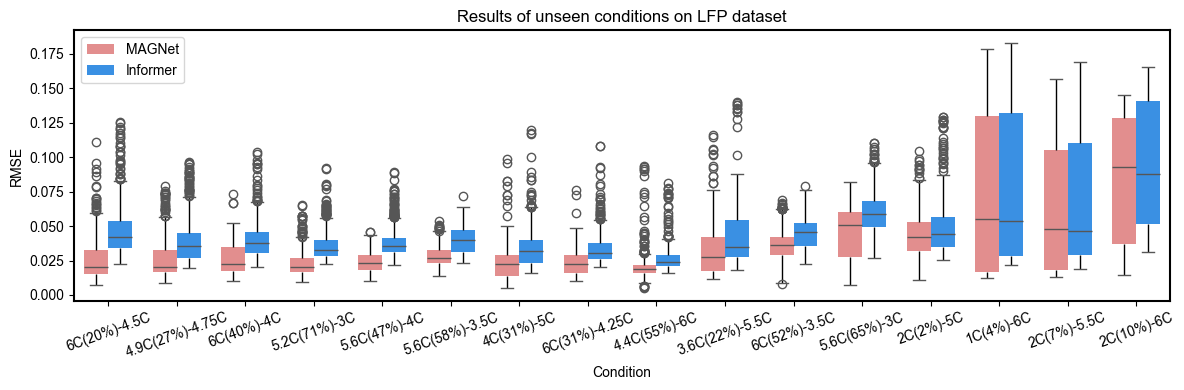

In [16]:
plot_LFP_seen_unseen_boxes(LFP_model_paths, rank_from_large_imrpvoement_to_low=True)